# Modeling – Passed and Archived Bills Only Using 'Party' Feature

## Importing Python Packages

In [1]:
# For loading, manipulating dataframe.
import pandas as pd
import sqlite3, datetime, sklearn

# Visualizations
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

# Text Preprocessing
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer

# Sampling
from imblearn.under_sampling import RandomUnderSampler 

# Vectorizers
from sklearn.feature_extraction.text import TfidfVectorizer

# Feature Processing 
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer

# Model Selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Modeling
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn import metrics

# Hide Warning messages
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_congress = pd.read_csv('congress_data_set.csv',index_col=0)

In [3]:
df_congress.shape

(15078, 22)

In [4]:
df_congress.head(2)

,bill_id,num,congress,long_title,date_filed,scope,status,author,date_lastUpdate,passed,...,Bloc,Years of Service,num_authors,delta_days,upper,mon,quarter,scope_national,majority_bloc,len_desc
0,17SBN-2235,SBN-2235,17,an act establishing the fiscal regime for the ...,5/28/19,National,"Pending Second Reading, Special Order","Drilon, Franklin M., Recto, Ralph G., Sotto II...",5/28/19,False,...,Minority,24,4,0,False,5,2,True,False,61
1,17SBN-2234,SBN-2234,17,an act authorizing the sale of certain parcels...,5/27/19,National,Approved by the President of the Philippines,"Recto, Ralph G., Sotto III, Vicente C., Escude...",6/30/19,True,...,Majority,18,3,34,False,5,2,True,True,300


## Feature Selection

In [5]:
df_congress=df_congress[(df_congress.status=='Sent to the Archives') | (df_congress.passed==True)]
print(f"df_congress Data Points: {df_congress.shape[0]:,}")

df_congress Data Points: 529


In [7]:
import pickle
df_tm = pickle.load(open("df_topic_model.pkl", "rb"))
new_df_tm = df_tm[df_tm.bill_status!='Pending']
new_df_tm.shape
new_df = pd.merge(new_df_tm,df_congress,on=['bill_id'])

In [8]:
new_df.columns

Index(['bill_id', 'long_title_x', 'bill_status', 't_0', 't_1', 't_2', 't_3',
       't_4', 't_5', 't_6', 't_7', 't_8', 't_9', 'num', 'congress',
       'long_title_y', 'date_filed', 'scope', 'status', 'author',
       'date_lastUpdate', 'passed', 'Full Name Primary Author', 'Party',
       'Bloc', 'Years of Service', 'num_authors', 'delta_days', 'upper', 'mon',
       'quarter', 'scope_national', 'majority_bloc', 'len_desc'],
      dtype='object')

In [9]:
cols_of_interest = ['Party','Years of Service','num_authors','delta_days', 'mon','scope_national', 'majority_bloc', 
                    'len_desc','passed','t_0', 't_1', 't_2', 't_3','t_4', 't_5', 't_6', 't_7', 't_8', 't_9']
df_tocorr = new_df[cols_of_interest]

In [10]:
df_tocorr.shape

(511, 19)

In [11]:
columnsToEncode=df_tocorr.select_dtypes(include=[object]).columns
df_tocorr = pd.get_dummies(df_tocorr, columns=columnsToEncode, drop_first=True)

In [12]:
df_tocorr.shape

(511, 31)

In [13]:
df_tocorr.loc[df_tocorr.mon==1,'month']='January'
df_tocorr.loc[df_tocorr.mon==2,'month']='February'
df_tocorr.loc[df_tocorr.mon==3,'month']='March'
df_tocorr.loc[df_tocorr.mon==4,'month']='April'
df_tocorr.loc[df_tocorr.mon==5,'month']='May'
df_tocorr.loc[df_tocorr.mon==6,'month']='June'
df_tocorr.loc[df_tocorr.mon==7,'month']='July'
df_tocorr.loc[df_tocorr.mon==8,'month']='August'
df_tocorr.loc[df_tocorr.mon==9,'month']='September'
df_tocorr.loc[df_tocorr.mon==10,'month']='October'
df_tocorr.loc[df_tocorr.mon==11,'month']='November'
df_tocorr.loc[df_tocorr.mon==12,'month']='December'

In [14]:
df_tocorr.dtypes

Years of Service          int64
num_authors               int64
delta_days                int64
mon                       int64
scope_national             bool
majority_bloc              bool
len_desc                  int64
passed                     bool
t_0                       int64
t_1                       int64
t_2                       int64
t_3                       int64
t_4                       int64
t_5                       int64
t_6                       int64
t_7                       int64
t_8                       int64
t_9                       int64
Party_Bagumbayan-VNP      uint8
Party_Independent         uint8
Party_LDP                 uint8
Party_Lakas               uint8
Party_Lakas-CMD           uint8
Party_Lakas-Kampi-CMD     uint8
Party_Liberal             uint8
Party_NPC                 uint8
Party_Nacionalista        uint8
Party_PDP_Laban           uint8
Party_PMP                 uint8
Party_PRP                 uint8
Party_UNA                 uint8
month   

In [15]:
columnsToEncode=df_tocorr.select_dtypes(include=[object]).columns
df_tocorr = pd.get_dummies(df_tocorr, columns=columnsToEncode, drop_first=True)

In [16]:
df_tocorr.dtypes

Years of Service         int64
num_authors              int64
delta_days               int64
mon                      int64
scope_national            bool
majority_bloc             bool
len_desc                 int64
passed                    bool
t_0                      int64
t_1                      int64
t_2                      int64
t_3                      int64
t_4                      int64
t_5                      int64
t_6                      int64
t_7                      int64
t_8                      int64
t_9                      int64
Party_Bagumbayan-VNP     uint8
Party_Independent        uint8
Party_LDP                uint8
Party_Lakas              uint8
Party_Lakas-CMD          uint8
Party_Lakas-Kampi-CMD    uint8
Party_Liberal            uint8
Party_NPC                uint8
Party_Nacionalista       uint8
Party_PDP_Laban          uint8
Party_PMP                uint8
Party_PRP                uint8
Party_UNA                uint8
month_August             uint8
month_De

In [17]:
df_tocorr.shape

(511, 42)

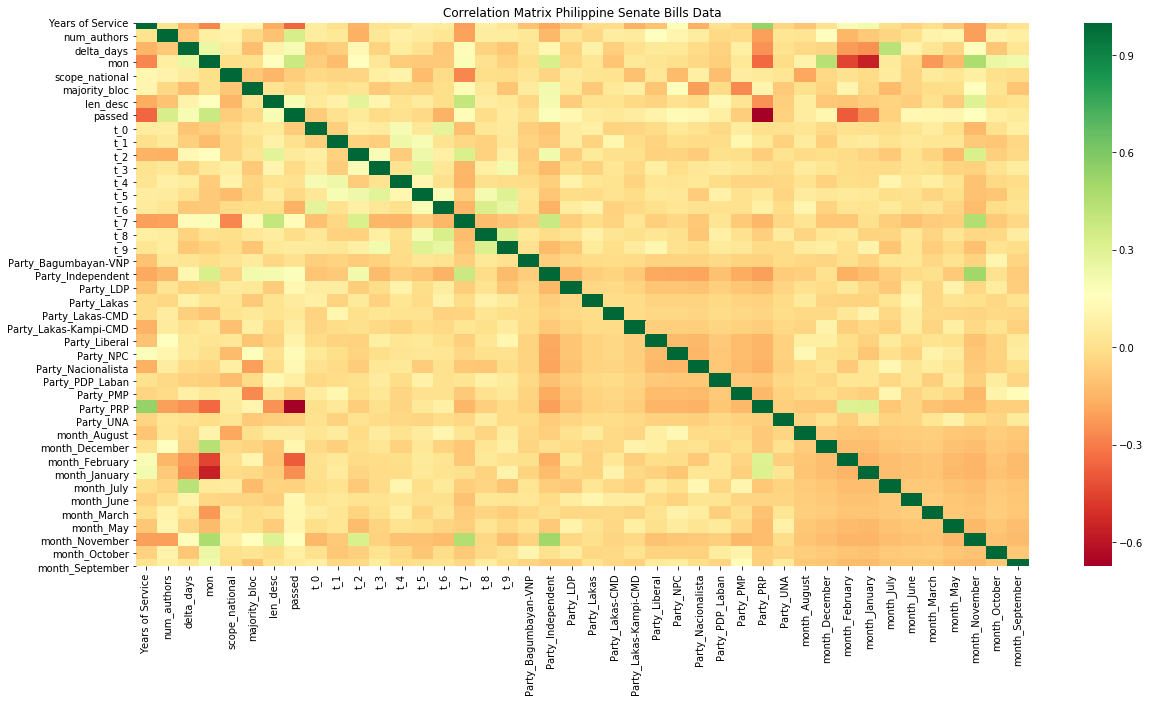

In [18]:
cor = df_tocorr.corr()
plt.figure(figsize=(20,10))
sns.heatmap(cor, annot=False,cmap="RdYlGn")
plt.title('Correlation Matrix Philippine Senate Bills Data')
plt.show()

In [19]:
df_tocorr = df_tocorr.drop(['mon','Years of Service'],axis=1)

In [20]:
df_tocorr.head()

,num_authors,delta_days,scope_national,majority_bloc,len_desc,passed,t_0,t_1,t_2,t_3,...,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
0,3,34,True,True,300,True,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,6,34,True,True,426,True,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,3,40,True,True,201,True,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,4,151,True,False,258,True,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,2,73,False,True,354,True,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


In [21]:
df_tocorr.shape

(511, 40)

In [22]:
pd.options.display.max_columns = None

In [23]:
cols_to_move = ['passed']
cols = [col for col in df_tocorr if col not in cols_to_move] + cols_to_move
df_tocorr = df_tocorr[cols]

In [24]:
df_tocorr.corr()

,num_authors,delta_days,scope_national,majority_bloc,len_desc,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,Party_Bagumbayan-VNP,Party_Independent,Party_LDP,Party_Lakas,Party_Lakas-CMD,Party_Lakas-Kampi-CMD,Party_Liberal,Party_NPC,Party_Nacionalista,Party_PDP_Laban,Party_PMP,Party_PRP,Party_UNA,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September,passed
num_authors,1.000000,-0.084444,0.102729,-0.029431,-0.099191,0.060875,0.042712,-0.158033,0.035895,0.080470,0.052659,0.029793,-0.197621,0.058745,0.060685,0.034125,-0.131656,0.024909,-0.028995,0.066949,0.052286,0.163306,0.104747,0.066084,-0.025102,-0.017920,-0.203669,0.028802,0.024584,0.157800,-0.140898,-0.076733,-0.038008,0.001028,0.100320,0.107210,-0.204257,0.095895,0.072078,0.338682
delta_days,-0.084444,1.000000,0.055249,-0.116183,0.098533,-0.097782,-0.053195,0.127665,-0.042475,0.059050,0.008541,-0.083375,0.139199,-0.042439,-0.083964,0.021864,0.112703,-0.040453,0.085307,-0.057769,0.006617,0.044661,0.039344,-0.018690,-0.048895,0.080208,-0.238051,0.010396,-0.020940,-0.036704,-0.222438,-0.242777,0.425797,0.093992,0.030599,-0.034224,0.150898,-0.086604,0.030190,0.197351
scope_national,0.102729,0.055249,1.000000,-0.091902,-0.140429,-0.023123,-0.037910,-0.036533,0.075496,0.092491,-0.121209,-0.018423,-0.271768,-0.002197,-0.010255,0.022519,-0.035241,0.050206,0.022519,0.016972,-0.110569,0.034906,-0.128161,0.072946,-0.112123,0.065001,0.046872,0.026996,-0.187220,-0.021718,0.009227,-0.020126,0.057181,-0.036175,0.046869,0.030184,0.074226,0.005573,-0.008530,-0.059760
majority_bloc,-0.029431,-0.116183,-0.091902,1.000000,0.023129,0.038247,0.002360,0.023668,-0.073844,-0.035476,-0.043115,-0.003160,0.132209,0.035220,-0.098668,0.056682,0.218239,0.044837,-0.072624,0.042721,0.074585,-0.096403,0.175428,-0.207328,-0.016410,-0.263620,0.108380,-0.076727,0.005730,-0.042371,0.108431,-0.020972,-0.129686,-0.036699,-0.011950,-0.000707,0.157148,0.020921,-0.094543,-0.022724
len_desc,-0.099191,0.098533,-0.140429,0.023129,1.000000,0.049831,0.088138,0.282105,0.108578,0.013955,0.052943,-0.001968,0.404063,0.071333,0.040476,-0.028286,0.213943,-0.069447,0.016973,0.012695,-0.021690,-0.044173,0.009257,-0.014640,0.127100,0.023510,-0.242578,-0.059016,0.063330,-0.085375,-0.095625,-0.063554,-0.046044,-0.062041,0.008192,-0.067880,0.304236,-0.008054,0.012835,0.201387
t_0,0.060875,-0.097782,-0.023123,0.038247,0.049831,1.000000,-0.058669,0.076545,0.057834,0.208498,0.033323,0.274186,-0.107792,0.033172,0.048406,-0.054490,-0.093364,0.066633,0.078102,-0.041068,-0.037775,-0.019682,0.038819,0.008509,-0.026040,0.061760,0.004710,0.008855,0.024120,-0.023093,0.008509,0.003038,-0.007431,0.024829,0.064223,-0.005638,-0.133947,0.007718,0.072514,-0.072130
t_1,0.042712,-0.053195,-0.037910,0.002360,0.088138,-0.058669,1.000000,-0.051808,-0.061311,0.239418,0.201945,0.018168,-0.026896,-0.047824,0.033065,-0.040511,-0.078899,0.065079,-0.040511,0.113932,-0.011270,-0.042728,-0.006733,-0.016600,-0.013219,0.112727,0.043754,-0.048565,0.057092,-0.054661,0.040714,0.055066,0.013017,0.039179,0.025737,0.029213,-0.076952,-0.088848,-0.027505,0.006799
t_2,-0.158033,0.127665,-0.036533,0.023668,0.282105,0.076545,-0.051808,1.000000,0.194481,-0.072526,0.230853,0.081708,0.321165,-0.046416,0.077116,-0.068130,0.223783,-0.060018,0.048436,-0.000100,-0.000175,-0.050238,-0.042501,-0.071594,0.005201,-0.004087,-0.065364,0.016143,-0.020117,-0.004490,-0.017375,-0.037236,-0.074336,0.013485,-0.044198,-0.122592,0.324050,-0.056215,-0.023174,0.051131
t_3,0.035895,-0.042475,0.075496,-0.073844,0.108578,0.057834,-0.061311,0.194481,1.000000,0.013173,0.284437,0.035849,-0.139010,0.074403,0.216230,-0.046564,-0.128613,-0.010623,-0.046564,0.029881,-0.023458,0.075246,-0.001810,0.038205,0.052320,0.034621,0.004574,-0.014481,0.055837,0.030855,-0.013352,-0.017762,-0.013994,0.012675,0.002083,-0.040502,-0.051692,0.016049,0.062609,-0.014833
t_4,0.080470,0.059050,0.092491,-0.035476,0.013955,0.208498,0.239418,-0.07

In [25]:
X = df_tocorr.drop('passed',axis=1)

In [26]:
X.shape

(511, 39)

In [27]:
y = df_tocorr['passed']

In [28]:
y.shape

(511,)

## Standardization

In [29]:
scaler = StandardScaler()

In [30]:
X = scaler.fit_transform(X)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=43)

In [32]:
print(f"Our new train set has {X_train.shape[0]} data points, {np.sum(y_train)} of which are actual positives.")

Our new train set has 383 data points, 322 of which are actual positives.


## SVC

In [33]:
svc = SVC(gamma='auto', kernel='linear', random_state = 42)
svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [34]:
predicted = svc.predict(X_test)

In [35]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

       False       0.83      0.86      0.84        28
        True       0.96      0.95      0.95       100

    accuracy                           0.93       128
   macro avg       0.89      0.90      0.90       128
weighted avg       0.93      0.93      0.93       128



## RF

In [36]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)

In [37]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [38]:
predicted = rf_model.predict(X_test)

In [39]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

       False       1.00      0.89      0.94        28
        True       0.97      1.00      0.99       100

    accuracy                           0.98       128
   macro avg       0.99      0.95      0.96       128
weighted avg       0.98      0.98      0.98       128



## k-Fold Cross Validation

In [ ]:
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
print(scores)

In [ ]:
# use average accuracy as an estimate of out-of-sample accuracy
print(scores.mean())

In [ ]:
# search for an optimal value of K for KNN
k_range = list(range(1, 31))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

In [ ]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.style.use('seaborn-dark')

plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

In [ ]:
# Best k for knn is 8. How about Logistic Regression?
# 10-fold cross-validation with logistic regression
logreg = LogisticRegression()
print(cross_val_score(logreg, X, y, cv=10, scoring='accuracy').mean())

In [ ]:
tree_model = DecisionTreeClassifier(random_state=42)
print(cross_val_score(tree_model, X, y, cv=10, scoring='accuracy').mean())

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
print(cross_val_score(rf_model, X, y, cv=10, scoring='accuracy').mean())

In [ ]:
# search for an optimal value of K for KNN
n_range = list(range(5, 15))
rf_scores = []
for n in n_range:
    rf_model = RandomForestClassifier(n_estimators=200, max_depth=n, random_state=42)
    scores = cross_val_score(rf_model, X, y, cv=10, scoring='accuracy')
    rf_scores.append(scores.mean())
print(rf_scores)

In [ ]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.style.use('seaborn-dark')

plt.plot(n_range, rf_scores)
plt.ylim(0.8, 1)
plt.xlabel('Value of n_estimators for RFC')
plt.ylabel('Cross-Validated Accuracy')